In [1]:
# 
# calculate the advection-diffusion equation
# using simpliest first-order numerical method

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

# constant variables
PI = math.pi

# time step
Dt = 10 # [s]

# grid resolution
Dx = 100 # [m]
Dy = 10 # [m]

# grid number

X_len = 8.0e4 # 4.6e4
Y_len = 1.6e3



Nx = int(X_len/Dx)
Ny = int(Y_len/Dy)

i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)

# define diffusion coefficient
Diff_x = 10.0 # [m2 s-1]
Diff_y = 0.5 # [m2 s-1]


center: 400 80


In [2]:
print( np.tan(2/180*PI) )

0.03492076949174773


U.shape: (160, 800)


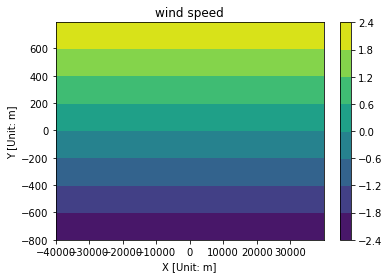

In [3]:
# define a fixed wind field
U_shear = 0.003 # [s-1]

V = np.zeros([Ny,Nx]) # [m]
U = np.zeros([Ny,Nx])
print('U.shape:',U.shape)

for j in range(Ny):
    U[j,:] = Y[j,:] * U_shear # [m]
    
plt.contourf(X,Y,U)
plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'wind speed' )
plt.show()


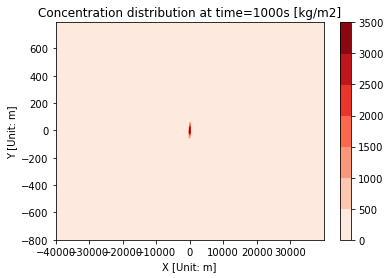

In [4]:
# *** Attention: this gaussian analytical results NOT requires Dv=Dh
# Chris J. Walcek-A Gaussian dispersionplume model explicitly accoun

t0 = 1000*1 # [s]

# gaussian analytical result
Sigma0_x = math.sqrt( 2.0*Diff_x*t0 ) # [m]
Sigma0_y = math.sqrt( 2.0*Diff_y*t0 ) # [m]

s = U_shear*t0* Sigma0_y/Sigma0_x

cc = 1e8 # [kg] or [kg/s]

C0_gau = np.zeros([Ny,Nx])

for j in range(Ny):
    for i in range(Nx):
        C0_gau[j,i] = cc/( 2*PI*Sigma0_x*Sigma0_y*math.sqrt(1+s**2/12) )* \
                        math.exp(-X[j,i]**2/(2*Sigma0_x**2*(1+s**2/12)) \
                                 -Y[j,i]**2*(1+s**2 /3)/(2*Sigma0_y**2*(1+s**2/12)) \
                                 +X[j,i]*Y[j,i]/(2*Sigma0_x*Sigma0_y)*(s/(1+s**2/12))
                                 )

contours = plt.contourf(X, Y, C0_gau, cmap='Reds')

plt.colorbar()
plt.title( 'Concentration distribution at time='+str(t0)+'s [kg/m2]' )
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')

plt.show()

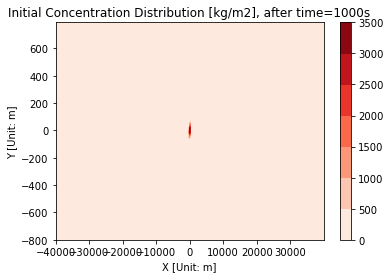

In [5]:
# define initial concentration distribution
Concnt = np.zeros([Ny,Nx])
C_old  = np.zeros([Ny,Nx])

#Concnt[j_init-2:j_init+3,i_init-2:i_init+3] = 1000.0 # [molec m2]
Concnt = C0_gau # [molec m2]

contours = plt.contourf(X, Y, Concnt, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(t0)+'s' )
plt.colorbar()

ynew = np.arange(0, 1000, 10)
xnew = ynew*U_shear*t0

theta = np.arctan( (xnew[2]-xnew[1])/(ynew[2]-ynew[1]) )
xnew2 = -ynew/np.tan(theta)
    
#plt.plot(xnew,ynew,'b')
#plt.plot(xnew2,ynew,'k')

plt.show()

In [6]:
# Lax–Wendroff Scheme

def Adv_Diff2(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    C2    = C*0.0
 
    i = Nx
    j = Ny

    alpha = Dt*U[:,1:i-1]/Dx
    C2[:,1:i-1] = C[:,1:i-1] - 0.5*alpha*(C[:,2:i]-C[:,0:i-2]) \
                          + 0.5*alpha**2*(C[:,2:i]-2*C[:,1:i-1]+C[:,0:i-2])
    
#     for j in range(0,Ny,1):
#         alpha = Dt*U[j,1]/Dx
#         C2[j,1:i-1] = C[j,1:i-1] - 0.5*alpha*(C[j,2:i]-C[j,0:i-2]) \
#                             + 0.5*alpha**2*(C[j,2:i]-2*C[j,1:i-1]+C[j,0:i-2])
                    
    C_new[1:j-1,1:i-1] = C2[1:j-1,1:i-1] + Dt*(Diff_x*(C2[1:j-1,0:i-2]+C2[1:j-1,2:i]-2*C2[1:j-1,1:i-1])/(Dx*Dx) \
                                             + Diff_y*(C2[0:j-2,1:i-1]+C2[2:j,1:i-1]-2*C2[1:j-1,1:i-1])/(Dy*Dy) )
    
    return C_new

In [7]:
# Test confusion CFL condition
if 2*Diff_y*Dt/(Dy**2)>1:
    print('****************************************')
    print('WARNING: Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt')
    print('****************************************')
    
if 2*Diff_x*Dt/(Dx**2)>1:
    print('****************************************')
    print('WARNING: X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt/Dx>1:
    print('****************************************')
    print('WARNING: X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [8]:
mass11 = np.sum(Concnt, axis=(0,1))

In [9]:
%%time

# time run
Nt = int(3600*6/Dt)
time = t0+Nt*Dt

Concnt1 = Concnt
for t in range(Nt):   
    Concnt1 = Adv_Diff2(Concnt1, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny)


CPU times: user 6.01 s, sys: 44.9 ms, total: 6.05 s
Wall time: 6.07 s


In [10]:
mass22 = np.sum(Concnt1, axis=(0,1))
mass11 = np.sum(C0_gau, axis=(0,1))
print(mass11, mass22, (mass22-mass11)/mass11 )

100000.0 99999.97235716078 -2.7642839224427005e-07


In [11]:
# *** Attention: this gaussian analytical results does NOT requires Dv=Dh
# Chris J. Walcek-A Gaussian dispersionplume model explicitly accoun

# gaussian analytical result
Sigma_x = math.sqrt( 2.0*Diff_x*time ) # [m]
Sigma_y = math.sqrt( 2.0*Diff_y*time ) # [m]

s = U_shear*time* Sigma_y/Sigma_x

C_gau = np.zeros([Ny,Nx])

for j in range(Ny):
    for i in range(Nx):
        C_gau[j,i] = cc/( 2*PI*Sigma_x*Sigma_y*math.sqrt(1+s**2/12) )* \
                        math.exp(-X[j,i]**2/(2*Sigma_x**2*(1+s**2/12)) \
                                 -Y[j,i]**2*(1+s**2 /3)/(2*Sigma_y**2*(1+s**2/12)) \
                                 +X[j,i]*Y[j,i]/(2*Sigma_x*Sigma_y)*(s/(1+s**2/12))
                                 )
print(Sigma_x)
print(Sigma_x*math.sqrt(1+s**2/12))  




672.3094525588645
3018.1752765536994


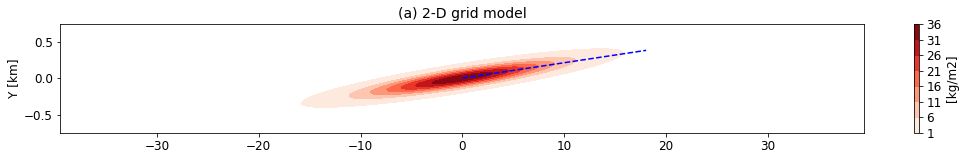

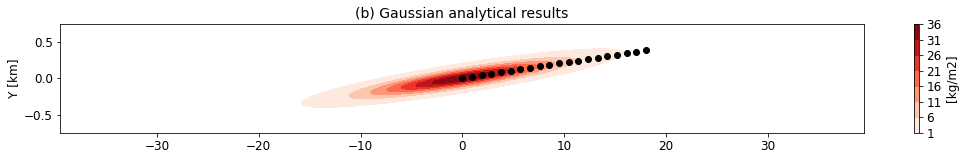

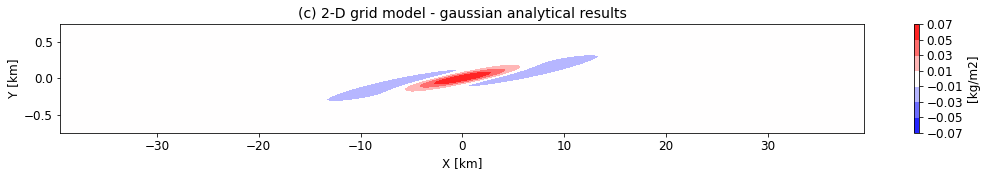

In [58]:
# plot 2-D model

ynew = np.arange(0, 400, 20)
xnew = ynew*U_shear*time*0.7
L = np.sqrt(ynew**2+xnew**2)

theta = np.arctan( (xnew[2]-xnew[1])/(ynew[2]-ynew[1]) )
xnew2 = -ynew/np.tan(theta)
S = np.sqrt(ynew**2+xnew2**2)



levs = np.arange(1,37,5)

fig, ax = plt.subplots(1, figsize=(18,2))
contours = plt.contourf(X[5:-5,5:-5]/1000, Y[5:-5,5:-5]/1000, Concnt1[5:-5,5:-5], \
                        levs, cmap='Reds')

plt.plot(xnew/1000,ynew/1000,'b--')

cbar = plt.colorbar()
cbar.ax.set_ylabel('[kg/m2]',fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.title('(a) 2-D grid model',fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Y [km]',fontsize=12)



plt.show()



# plot guassian
fig, ax = plt.subplots(1, figsize=(18,2))
contours = plt.contourf(X[5:-5,5:-5]/1000, Y[5:-5,5:-5]/1000, C_gau[5:-5,5:-5], levs, cmap='Reds')

plt.plot(xnew/1000,ynew/1000,'ko')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('[kg/m2]',fontsize=12)

plt.title( '(b) Gaussian analytical results',fontsize=14 )

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Y [km]',fontsize=12)


#plt.plot(xnew,ynew)
plt.show()


# plot the concentration difference
C_diff = Concnt1[5:-5,5:-5] - C_gau[5:-5,5:-5]

levs = np.arange(-7,9,2)*0.01

fig, ax = plt.subplots(1, figsize=(18,2))
contours = plt.contourf(X[5:-5,5:-5]/1000, Y[5:-5,5:-5]/1000, C_diff, levs, cmap='bwr')

cbar = plt.colorbar(contours)
cbar.ax.set_ylabel('[kg/m2]',fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.title( '(c) 2-D grid model - gaussian analytical results',fontsize=14 )

plt.xticks(fontsize=12)
plt.xlabel('X [km]',fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Y [km]',fontsize=12)

#plt.plot(xnew,ynew)
plt.show()

# plt.tight_layout()

(20, 1)


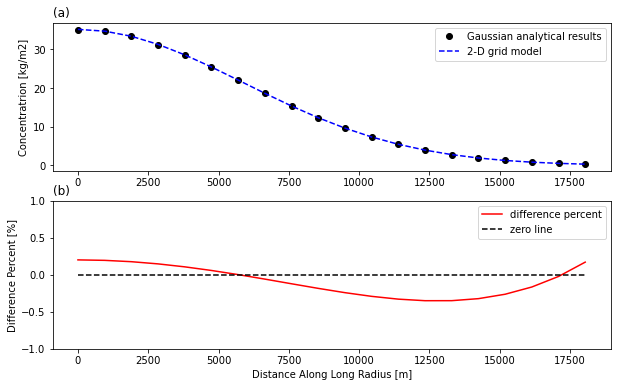

running time=6.0 h, begin at t0=0.2777777777777778 h
S=0.003 s-1, Dh=10.0 m2/s, Dv=0.5 m2/s, Dx=100 m, Dy=10 m


In [59]:
# Interpolation along the long_radius direction

ff1 = interpolate.interp2d(x, y, Concnt1, kind='linear')
ff2 = interpolate.interp2d(x, y, C_gau, kind='linear')

N = len(ynew)

C1_new = []
C2_new = []

for i in range(N):
    C1_new.append( ff1(xnew[i], ynew[i]) )
    C2_new.append( ff2(xnew[i], ynew[i]) )

Concnt1_new = np.array(C1_new)
Concnt2_new = np.array(C2_new)

print(Concnt1_new.shape)
L = np.sqrt(ynew**2+xnew**2)

fig, ax = plt.subplots(2,figsize=(10,6))

ax[0].plot(L,Concnt2_new,'ko',label='Gaussian analytical results')
ax[0].plot(L,Concnt1_new,'b--',label='2-D grid model')


ax[0].set_ylabel('Concentratrion [kg/m2]')
ax[0].set_title('(a)', loc='left')
ax[1].set_ylim(0,30)
ax[0].legend()


ax[1].plot(L,(Concnt1_new-Concnt2_new)/Concnt2_new*100,'r',label='difference percent')
ax[1].plot(L,0.0*(Concnt1_new-Concnt2_new),'k--',label='zero line')

ax[1].set_ylim(-1,1)
ax[1].set_xlabel('Distance Along Long Radius [m]')
ax[1].set_ylabel('Difference Percent [%]')
ax[1].set_title('(b)', loc='left')
#ax[1].set_title('Concentration difference distribution along the long radius
#(2-D model-Gaussian analytic results)')
ax[1].legend()


plt.show()

print('running time='+str((time-t0)/3600)+' h, begin at t0='+str(t0/3600)+' h' )
print('S={} s-1, Dh={} m2/s, Dv={} m2/s, Dx={} m, Dy={} m'.format(U_shear, Diff_x, Diff_y, Dx, Dy))
